In [1]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Things that you need to have in your head 



In [17]:
"""
ETL - PLTV Bubble Arena
""" 

# Configure load path
import pickle
import pandas as pd
import os
import requests
from urllib.parse import urlencode
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, r2_score, d2_absolute_error_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
import xgboost as xgb
from dateutil.relativedelta import relativedelta
from tqdm import tqdm, tqdm_notebook
import numpy as np
import random
import json
from datetime import datetime, timedelta
import re
from sklearn.model_selection import TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score
from sklearn.tree    import DecisionTreeRegressor
from sklearn.tree    import DecisionTreeClassifier
import itertools

os.chdir("C:/Users/Win11/Documents/")
os.chdir("C:/Users/Win11/Documents/Repos/Poker-Hit-PLTV/")

bs_token = 'S7Fek4qridIxY1sUfYUyOl0rLak1Eedeg0TTCWHzUHqIFuUGN07xZtd41ZCp2UvE'  # Token Bingo Arena
host = 'td.winnerstudio.vip'

# Path Thinking Engine tables
tables_path = 'tables_etl_script_poker_hit.py'
start_date = '2023-08-15'
end_date = (datetime.now() - timedelta(days = 120)).strftime('%Y-%m-%d')
client_name = 'ios'

# Load queries from remote python script (This needs to be perfect).  Overall, you might want to have the lsit here
exec(open(tables_path).read())
tables = locals().get('tables')


# Data pull

### Version all 

In [3]:
# If you have problems with the data load you can add a try and except and then just keep what you had before breaking connection. 
def load_data(bs_token, host):

    def pull_data(sql_script, bs_token, host):

        data = {
            'token':          bs_token,
            'format':         'json_object',
            'timeoutSeconds': 20000,
            'sql':            sql_script
        }

        data = str(urlencode(data))
        response = requests.post(f'http://{host}:8992/querySql?{data}', timeout = 1000000)

        # Sample list of JSON strings
        json_list = response.text.split('\n')[1:]

        # Convert JSON strings to dictionaries
        dict_list = []
        for json_str in json_list:
            try:
                dict_list.append(json.loads(json_str))
            except json.JSONDecodeError as e:
                print(f"Error parsing JSON: {e}")

        # Create a pandas DataFrame
        data = pd.DataFrame(dict_list).sort_index(axis = 1)
        print('+1')
        # Display the DataFrame
        return data

    # Load the first data using USER_PAYMENT, and then iteatevely join the remaining data for trainning
    df = pull_data(tables[0], bs_token, host)
    print(df.columns)
    for i in range(1, len(tables)):
        new_data = pull_data(tables[i], bs_token, host)
        print(new_data.head(2))
        df = df.merge(new_data, on = '#account_id')

    df['#account_id'] = df['#account_id'].astype(str) # One of them might not be recommended since it is already a string
    df['register_time'] = pd.to_datetime(df['register_time'], errors = 'coerce')
    return df

# Create df by loading information and joining on account_id
df = load_data(bs_token, host)
df.shape

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
+1
Index(['#account_id', 'cp1', 'cp3', 'cp7', 'p1', 'p10', 'p100', 'p105', 'p11',
       'p112', 'p119', 'p12', 'p126', 'p13', 'p133', 'p14', 'p15', 'p16',
       'p17', 'p18', 'p19', 'p2', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25',
       'p26', 'p27', 'p28', 'p3', 'p35', 'p4', 'p42', 'p49', 'p5', 'p56', 'p6',
       'p63', 'p7', 'p70', 'p77', 'p8', 'p84', 'p9', 'p91', 'p98', 'ph1',
       'ph6', 'register_time'],
      dtype='object')
Error parsing JSON: Expecting value: line 1 column 1 (char 0)
+1
  #account_id  failed_p1  failed_p3  failed_p7  failed_ph6
0     2148355          0          0          0           0
1     2148623          0          0          0           0
Error parsing JSON: Expecting value: line 1 column 1 (char 0)
+1
  #account_id   w1  w10  w100  w105  w11  w112  w119  w12  w126  ...  w56  \
0     2147500  0.0  0.0   0.0   0.0  0.0   0.0   0.0  0.0   0.0  ...  0.0   
1     2148402  0.0  0.0   0.0   0.0  

(15035, 102)

In [4]:
df['#account_id'] = df['#account_id'].astype(str)
df['register_time'] = pd.to_datetime(df['register_time'], errors = 'coerce')
df = df.fillna(0)

In [5]:
# Calculate differences
day_columns = ['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7']
for i in range(len(day_columns) - 1, 0, -1):
    df[f'{day_columns[i]}_diff'] = df[day_columns[i]] - df[day_columns[i - 1]]

In [6]:

diff_columns_names = [col for col in df.columns if col.endswith('_diff')]
payment_cols = diff_columns_names + ['w7'] + ['p1'] + ['ph6'] + ['cp7'] + ['cp1'] + ['d7_28_increment']

df['d7_28_increment'] = df['p28'] - df['w28'] - (df['p7'] - df['w7'])
# payment_cols = diff_columns_names + ['ad7'] + ['w7'] + ['p1'] + ['d7_28_increment'] # + ['cp1'] #+ ['paid_6h']


In [7]:
# Add predictions
integers_list = list(range(7, 28))
incremented_numbers = [str(number) for number in range(28, 36, 7)]
predictors_days_input = predictors_days = [str(integer) for integer in integers_list] + incremented_numbers

# Available dates as target (I am considering adding more values, above and below, maybe up to two on each side)
response_days_input = response_days = ["14", "28", "56", "63", "70", "77", "84", "91", "98", "100", "105", "112", "119", "126", "133"]

### Version table by table

In [53]:
# If you have problems with the data load you can add a try and except and then just keep what you had before breaking connection. 

def pull_data(sql_script, bs_token, host):

    data = {
        'token':          bs_token,
        'format':         'json_object',
        'timeoutSeconds': 20000,
        'sql':            sql_script
    }

    data = str(urlencode(data))
    response = requests.post(f'http://{host}:8992/querySql?{data}', timeout = 1000000)

    # Sample list of JSON strings
    json_list = response.text.split('\n')[1:]

    # Convert JSON strings to dictionaries
    dict_list = []
    for json_str in json_list:
        try:
            dict_list.append(json.loads(json_str))
        except json.JSONDecodeError as e:
            print(f"Error parsing JSON: {e}")

            # Create a pandas DataFrame
            data = pd.DataFrame(dict_list).sort_index(axis = 1)
            print('+1')
            # Display the DataFrame
            return data


In [54]:
# Load queries from remote python script (This needs to be perfect).  Overall, you might want to have the lsit here
exec(open(tables_path).read())
tables = locals().get('tables')

### Calculation validation

This step maybe I will jump it for higher speed

In [ ]:
## Load API


In [ ]:
## Give me payment: 


In [ ]:
## Give me withdrawal: 


In [ ]:
## Give me ad revenue:


# Find 

In [9]:
# Pipeline functions definition 

def create_huber(alpha, epsi, cols): 
    
    columns = cols
    preprocessor = ColumnTransformer(
        transformers = [
            ('scaler', StandardScaler(), columns)
        ],
        remainder='passthrough'
    )
    
    # Create the pipeline
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', HuberRegressor(fit_intercept=True, epsilon=epsi, alpha=alpha, warm_start=False, max_iter=1200))
    ])

    return pipe

def all_feature_enginerring(data, response):

    """
    This is better to create before and the just utilise it in whatever model
        - Notice what you're doing with withdrawal day 100 (I am not so interested in withdrawal but it is fine)
    """
    
    # Payment predictor 
    xgbt = xgb.XGBClassifier(min_samples_leaf = 500)
    xgbt.fit(data, (response > 0.01).astype(int))
    data['payer_model'] = xgbt.predict_proba(data)[:, 1]

    # Outlier predictor 
    dt = DecisionTreeClassifier(random_state = 42, min_samples_leaf = 1500)
    dt.fit(data, (response > 300).astype(int))
    data['oulier_model'] = dt.predict_proba(data)[:, 1]

    # Inclusion of interpolation 
    column_list = ['p7_diff', 'p3_diff', 'p1', 'w7']
    column_combinations = list(itertools.combinations(column_list, 2))

    for pair in column_combinations:
        column1, column2 = pair
        new_column_name = f"{column1}_times_{column2}"
        data[new_column_name] = data[column1] * data[column2]  # Example: Multiply values of two columns

    # Some divisions 
    # data['payment_growth'] = data['p7_diff'] / data['money_status_d7']

    return data


In [12]:
validation_sets = 3
df['date'] = df['register_time'].apply(lambda x: int(x.strftime('%Y%m%d')))
df['validation_set_id'] = pd.qcut(df['date'].values, validation_sets)

df.groupby('validation_set_id').size()


validation_set_id
(20230814.999, 20230826.0]    5026
(20230826.0, 20230907.0]      5312
(20230907.0, 20230917.0]      4697
dtype: int64

In [13]:

model_results = []
all_model_results = []
alphas = [0.01, 0.05, 0.02, 0.05, 0.1] 
epsils = [1.3, 1.5, 1.7, 2, 2.5] 

# for train_index, test_index in splits:
for date_group in df['validation_set_id'].unique():

    train_data =  df[df['validation_set_id'] != date_group][payment_cols]
    test_data =  df[df['validation_set_id'] == date_group][payment_cols]

    # Separate features (X) and target variable (y)
    X_train, y_train = train_data.drop(columns = [f'd7_28_increment']), train_data[f'd7_28_increment']
    X_test, y_test = test_data.drop(columns = [f'd7_28_increment']), test_data[f'd7_28_increment']

    old_cols = X_train.copy().columns
    X_train = all_feature_enginerring(X_train, y_train)
    X_test = all_feature_enginerring(X_test, y_test)

    for alpha in alphas: 

        for epsi in epsils: 
        
            for cols in [old_cols, X_train.columns]:
                
                print(alpha, epsi, cols)
                # Full trainning and testing 
                model = create_huber(alpha, epsi, cols)

                try: 
                    model.fit(X_train[cols], y_train)
                    predictions = model.predict(X_test[cols])
                    mae = mean_absolute_error(y_test, predictions)
                    r2 = r2_score(y_test, predictions)

                except: 
                    model = np.nan
                    predictions = np.nan
                    mae = np.nan
                    r2 = np.nanZ
                
                # Save the model into dictionary (Response, day, mo...)
                model_result = pd.DataFrame({
                    'Iteration': [str(alpha) + ' - ' + str(epsi) + ' - ' + str(len(cols))]
                    , 'Test at': [date_group]
                    , 'Model': [model]
                    , 'mae': [mae]
                    , 'r2': [r2]
                    , 'rel_mae': [(((y_test - y_test.mean()).abs()).mean() - mae) / (((y_test - y_test.mean()).abs()).mean())]
                })

                model_results.append(model_result)
    
    all_model_results.extend(model_results)


[14:52:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf" } are not used.

[14:52:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf" } are not used.

0.01 1.3 Index(['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7',
       'p1', 'ph6', 'cp7', 'cp1'],
      dtype='object')
0.01 1.3 Index(['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7',
       'p1', 'ph6', 'cp7', 'cp1', 'payer_model', 'oulier_model',
       'p7_diff_times_p3_diff', 'p7_diff_times_p1', 'p7_diff_times_w7',
       'p3_diff_times_p1', 'p3_diff_times_w7', 'p1_times_w7'],
      dtype='object')
0.01 1.5 Index(['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7',
       'p1', 'ph6', 'cp7', 'cp1'],
      dtyp

In [39]:
# all_model_results = pd.concat(all_model_results, ignore_index = True)#.sort_values(by = ['Available day', 'Model'])
all_model_results.sort_values(by = 'mae').tail(10)

,Iteration,Test at,Model,mae,r2,rel_mae
239,0.05 - 2.5 - 19,"(20230826.0, 20230907.0]","(ColumnTransformer(remainder='passthrough',\n ...",5.138495,-0.425969,0.409236
219,0.05 - 2.5 - 19,"(20230826.0, 20230907.0]","(ColumnTransformer(remainder='passthrough',\n ...",5.138495,-0.425969,0.409236
139,0.05 - 2.5 - 19,"(20230826.0, 20230907.0]","(ColumnTransformer(remainder='passthrough',\n ...",5.138495,-0.425969,0.409236
119,0.05 - 2.5 - 19,"(20230826.0, 20230907.0]","(ColumnTransformer(remainder='passthrough',\n ...",5.138495,-0.425969,0.409236
109,0.01 - 2.5 - 19,"(20230826.0, 20230907.0]","(ColumnTransformer(remainder='passthrough',\n ...",5.182892,-0.597676,0.404132
209,0.01 - 2.5 - 19,"(20230826.0, 20230907.0]","(ColumnTransformer(remainder='passthrough',\n ...",5.182892,-0.597676,0.404132
127,0.02 - 2 - 19,"(20230826.0, 20230907.0]","(ColumnTransformer(remainder='passthrough',\n ...",5.214019,-0.638852,0.400553
227,0.02 - 2 - 19,"(20230826.0, 20230907.0]","(ColumnTransformer(remainder='passthrough',\n ...",5.214019,-0.638852,0.400553
147,0.1 - 2 - 19,"(20230826.0, 20230907.0]","(ColumnTransformer(remainder='passthrough',\n ...",5.243010,-0.651399,0.397220
247,0.1 - 2 - 19,"(20230826.0, 20230907.0]","(ColumnTransformer(remainder='passthrough',\n ...",5.243010,-0.651399,0.397220


In [40]:
Test_at = all_model_results['Test at'].max()
all_model_results[all_model_results['Test at'] == Test_at].sort_values(by = 'mae').head(10)

,Iteration,Test at,Model,mae,r2,rel_mae
267,0.05 - 2 - 19,"(20230907.0, 20230917.0]","(ColumnTransformer(remainder='passthrough',\n ...",2.667634,0.003637,0.449566
287,0.05 - 2 - 19,"(20230907.0, 20230917.0]","(ColumnTransformer(remainder='passthrough',\n ...",2.667634,0.003637,0.449566
257,0.01 - 2 - 19,"(20230907.0, 20230917.0]","(ColumnTransformer(remainder='passthrough',\n ...",2.694794,-0.037421,0.443962
299,0.1 - 2.5 - 19,"(20230907.0, 20230917.0]","(ColumnTransformer(remainder='passthrough',\n ...",2.696947,-0.015217,0.443518
297,0.1 - 2 - 19,"(20230907.0, 20230917.0]","(ColumnTransformer(remainder='passthrough',\n ...",2.714547,-0.053983,0.439886
291,0.1 - 1.3 - 19,"(20230907.0, 20230917.0]","(ColumnTransformer(remainder='passthrough',\n ...",2.715886,-0.082154,0.439610
285,0.05 - 1.7 - 19,"(20230907.0, 20230917.0]","(ColumnTransformer(remainder='passthrough',\n ...",2.733982,-0.032591,0.435876
265,0.05 - 1.7 - 19,"(20230907.0, 20230917.0]","(ColumnTransformer(remainder='passthrough',\n ...",2.733982,-0.032591,0.435876
259,0.01 - 2.5 - 19,"(20230907.0, 20230917.0]","(ColumnTransformer(remainder='passthrough',\n ...",2.739027,0.001237,0.434835
269,0.05 - 2.5 - 19,"(20230907.0, 20230917.0]","(ColumnTransformer(remainder='passthrough',\n ...",2.739542,-0.005085,0.434729


In [24]:
amrgb = all_model_results.groupby('Iteration')[['mae', 'r2', 'rel_mae']].mean().sort_values(by = 'rel_mae', ascending = False).reset_index(drop = False)
amrgb.head(10)


,Iteration,mae,r2,rel_mae
0,0.05 - 1.5 - 11,3.119624,0.089455,0.481799
1,0.02 - 1.5 - 11,3.126553,0.113168,0.477230
2,0.01 - 1.3 - 11,3.149894,0.102583,0.476105
3,0.01 - 2.5 - 11,3.160469,0.102048,0.472635
4,0.01 - 1.5 - 11,3.163610,0.107095,0.472545
5,0.05 - 2.5 - 11,3.168310,0.109757,0.471677
6,0.02 - 2.5 - 11,3.174727,0.087822,0.471633
7,0.02 - 1.3 - 11,3.170195,0.083903,0.471423
8,0.02 - 1.7 - 11,3.174350,0.067635,0.471276
9,0.1 - 1.3 - 11,3.171691,0.075818,0.470374


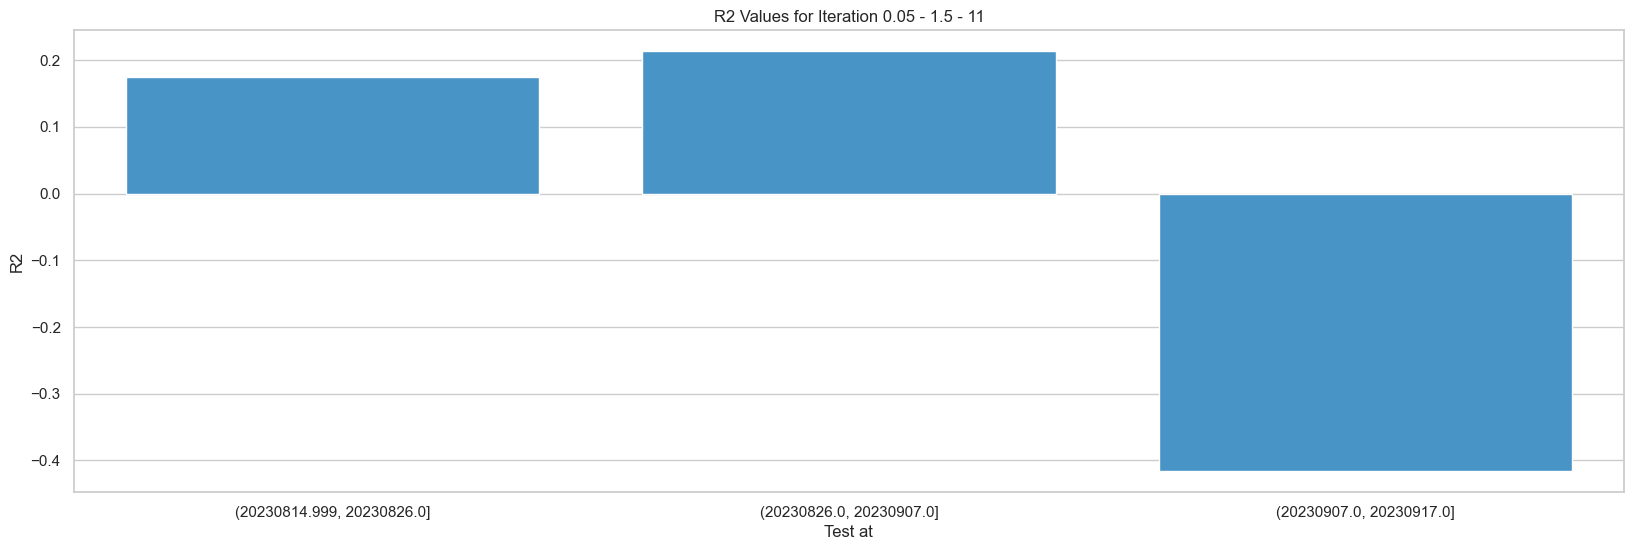

In [46]:
# yEs you could do a deeper check here. 

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df'
# Replace 'your_iteration_value' with the specific iteration you are interested in
iteration_value = '0.05 - 1.5 - 11'
# iteration_value = '0.05 - 2 - 19'
subset_df = all_model_results[all_model_results['Iteration'] == iteration_value]

# Set the seaborn style to a more professional one
sns.set(style="whitegrid")

# Create the Seaborn barplot for R2
plt.figure(figsize=(20, 6))

# Plotting R2 in a professional color
sns.barplot(x='Test at', y='r2', data=subset_df, color='#3498db')  # Use a professional blue color

plt.title(f'R2 Values for Iteration {iteration_value}')
plt.xlabel('Test at')
plt.ylabel('R2')
plt.show()


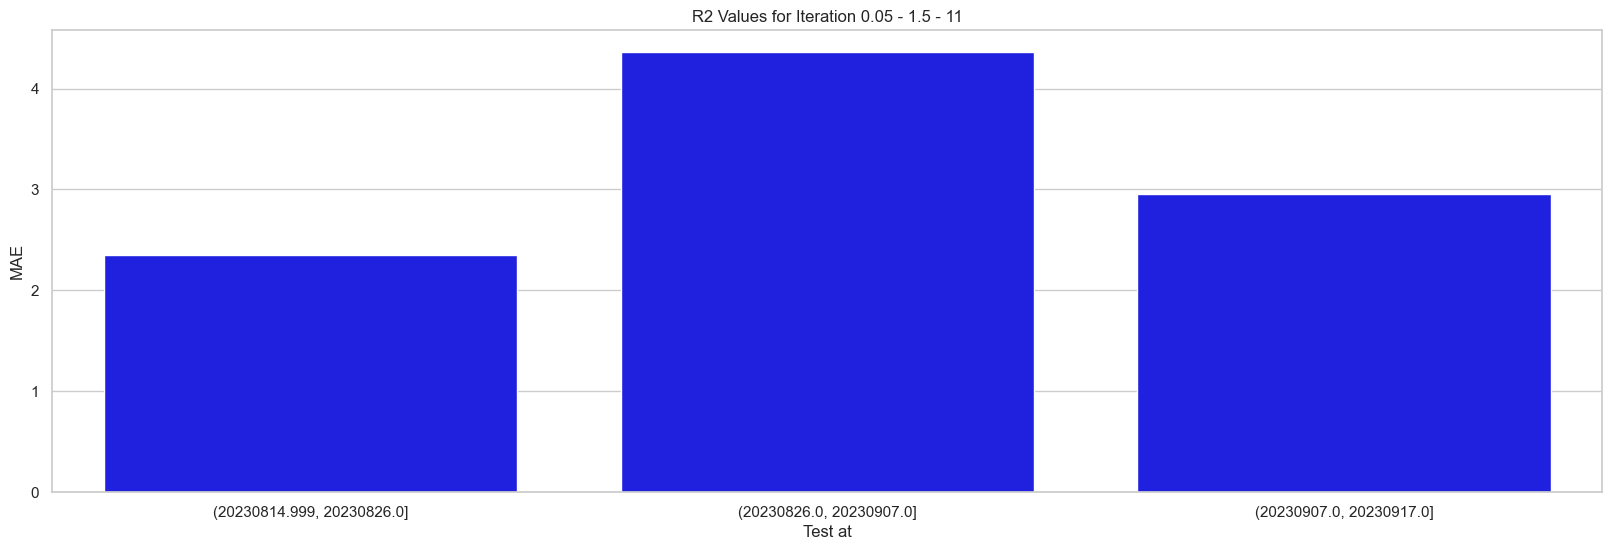

In [47]:
# Set the seaborn style to a more professional one
sns.set(style="whitegrid")

# Create the Seaborn barplot for R2
plt.figure(figsize=(20, 6))

# Plotting R2 in blue
sns.barplot(x='Test at', y='mae', data=subset_df, color='blue')

plt.title(f'R2 Values for Iteration {iteration_value}')
plt.xlabel('Test at')
plt.ylabel('MAE')
plt.show()

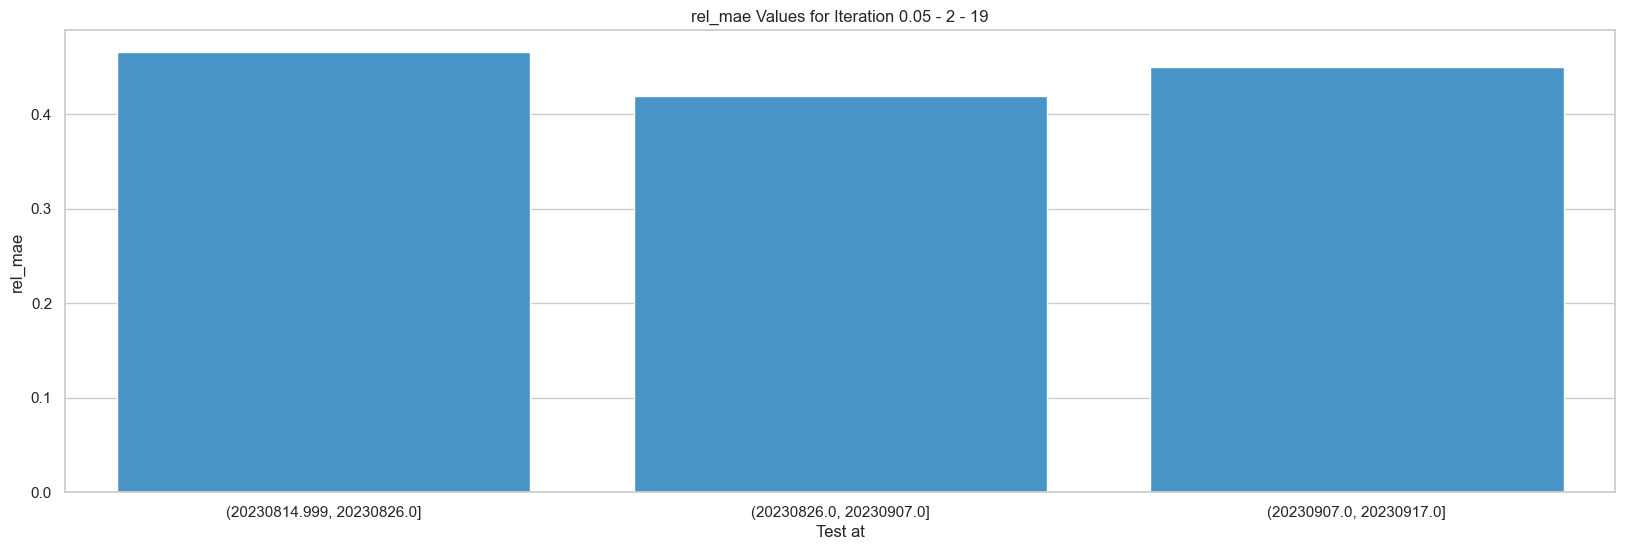

In [43]:
# Set the seaborn style to a more professional one
sns.set(style="whitegrid")

# Create the Seaborn barplot for R2
plt.figure(figsize=(20, 6))

# Plotting R2 in a professional color
sns.barplot(x='Test at', y='rel_mae', data=subset_df, color='#3498db')  # Use a professional blue color

plt.title(f'rel_mae Values for Iteration {iteration_value}')
plt.xlabel('Test at')
plt.ylabel('rel_mae')
plt.show()

In [48]:
model_value = all_model_results.loc[all_model_results['Iteration'] == iteration_value, 'Model'].iloc[0]
df_plus = all_feature_enginerring(df[payment_cols], df[f'd7_28_increment']).sample(3000)

cols_to_append = [
    'roas_d7_times_installs_difference',
    'withdrawn_ratio_times_installs_difference',
    'withdrawn_ratio_times_pred_8_28',
    'roas_d7_times_pred_8_28',
    'roas_d7_times_withdrawn_ratio',
    'pred_8_28_times_installs_difference'
]

subnormal = [col for col in old_cols if col != 'Installs']
# subnormal.extend(cols_to_append)
subnormal

predictions = model_value.predict(df_plus[subnormal])

[15:07:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf" } are not used.



In [49]:
import pandas as pd
import plotly.express as px

# Assuming reset_df is your DataFrame
pdf = pd.DataFrame({'y_test': df_plus[f'd7_28_increment'].values, 'predictions': predictions})

# Create a scatter plot with color-coded categories
fig = px.scatter(pdf, x = 'predictions', y = 'y_test', title = 'Association Actuals vs Predictions', trendline='ols',
                 labels = {'predictions': 'X-axis Label', 'y_test': 'Y-axis Label'},
                 template = 'plotly_dark',  # Choose a dark template for a professional look
                 hover_data = ['predictions', 'y_test'],  # Additional information on hover
                #  marginal_x = 'box',  # Display box plot on the x-axis
                #  marginal_y = 'violin'  # Display violin plot on the y-axis
                 )

# Customize the layout
fig.update_layout(
    width = 1500,  # Set the width in pixels
    height = 1000,  # Set the height in pixels
    xaxis = dict(title_text = 'Predicted'),
    yaxis = dict(title_text = 'Actual user revenue'),
    legend = dict(title = 'Legend Title'),
    showlegend = True
)

# Show the plot

# Fit to all combinations 

In [8]:
# old_cols = old_cols.to_list()
def create_huber(alpha, epsi, cols): 
    
    columns = cols
    preprocessor = ColumnTransformer(
        transformers=[
            ('scaler', StandardScaler(), columns)
        ],
        remainder='passthrough'
    )
    
    # Create the pipeline
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', HuberRegressor(alpha = alpha, epsilon = epsi, max_iter = 1000))
    ])

    return pipe

In [9]:
max_date = df['register_time'].max()
df['days_since_install'] = (max_date - df['register_time']).dt.total_seconds() / (60 * 60 * 24) # Needed? Yes
df['days_since_install']

0        33.0
1        33.0
2        32.0
3        30.0
4        29.0
         ... 
15030     2.0
15031     1.0
15032     1.0
15033     1.0
15034     0.0
Name: days_since_install, Length: 15035, dtype: float64

In [10]:
# List of day columns
day_columns = ['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7']

# Calculate differences
for i in range(len(day_columns) - 1, 0, -1):
    df[f'{day_columns[i]}_diff'] = df[day_columns[i]] - df[day_columns[i - 1]]
    

In [11]:
winner_cols = ['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'p1', 'ph6', 'cp7', 'cp1']


In [12]:
payback_predictive_system = []

for y_day in tqdm(response_days):

  for x_day in predictors_days:

    if int(y_day) > int(x_day):

      # Make the response (You need to work out how to get a bigger response):
      # df['y'] = df[f'p{y_day}'] + df[f'ad{y_day}'] - df[f'w{y_day}'] - (df[f'p{x_day}'] + df[f'ad{x_day}'] - df[f'w{x_day}'])
      df['y'] = df[f'p{y_day}'] - df[f'w{y_day}'] - (df[f'p{x_day}'] - df[f'w{x_day}'])
      y = df[df['days_since_install'] <= (int(y_day) - 1)]['y']
      del df['y']

      # Make the regressors

      ## I. Get the differentiations (The basics you should have obtained beforehand. So only the last one is okay)
      df[f'p_last_diff_7_{x_day}'] = df[f'p{x_day}'] - df[f'p7']
      df[f'w_last_diff_7_{x_day}'] = df[f'w{x_day}'] - df[f'w7']
      # df[f'ad_last_diff'] = df[f'ad{x_day}'] - df[f'ad7']
      
      selected_columns = winner_cols + [f'p_last_diff_7_{x_day}'] + [f'w_last_diff_7_{x_day}'] #+ [f'ad_last_diff']
      X = df[df['days_since_install'] <= (int(y_day) - 1)][selected_columns]
      model = create_huber(0.05, 1.5, selected_columns)
      model.fit(X, y)

      # Save the model into dictionary (Response, day, model)
      payback = pd.DataFrame({
              'Available day': [x_day]
              , 'Target day': [y_day]
              , 'Model': [model]
              , 'Columns': [X.columns]
              })

      payback_predictive_system.append(payback)

model_dict = pd.concat(payback_predictive_system, ignore_index = True)

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [03:21<00:00, 13.45s/it]


In [15]:
# Remove the last data points and remove the pred_ columns. This is too much
with open('poker_party_ios_ptlv_dictionary_2024_jan.pkl', 'wb') as file:
    pickle.dump(model_dict, file)

### Rubbish: by-query pull

In [ ]:
"""Payment data load
"""
df = pull_data(tables[0], bs_token, host)

In [117]:
# Withdrawal
new_data = pull_data(tables[1], bs_token, host)
df = df.merge(new_data, on = '#account_id')

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
+1


In [118]:
# Games played 
new_data = pull_data(tables[2], bs_token, host)
df = df.merge(new_data, on = '#account_id')

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
+1


In [119]:
# Games played 
new_data = pull_data(tables[3], bs_token, host)
df = df.merge(new_data, on = '#account_id')

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
+1


In [120]:
new_data = pull_data(tables[4], bs_token, host)
df = df.merge(new_data, on = '#account_id')

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
+1


In [43]:
df['#account_id'] = df['#account_id'].astype(str) # One of them might not be recommended since it is already a string
df['register_time'] = pd.to_datetime(df['register_time'], errors = 'coerce')

df = df.fillna(0)

# Modelling

In [13]:
df['d7_100_increment'] = df['p100'] - df['w100'] - (df['p7'] - df['w7'])

In [14]:
# Define available and target dates 
integers_list = list(range(8, 28))
incremented_numbers = [str(number) for number in range(28, 36, 7)]
predictors_days_input = predictors_days = [str(integer) for integer in integers_list] + incremented_numbers

response_days_input = response_days = ["14", "28", "56", "63", "70", "77", "84", "91", "98", "100", "105", "112", "119", "126", "133"]
extra_columns = ['is_us', 'is_de', 'is_gb', 'is_unknown_country','model_increment_prediction', 'model_d3_to_7_prediction', 'is_organic', 'huber_pred_outliers', 'huber_pred']

In [15]:
# Assuming df is your DataFrame
numeric_columns = df.select_dtypes(include=['number'])

# Get the names of numeric columns
numeric_column_names = numeric_columns.columns.tolist()
numeric_column_names = [col for col in numeric_columns.columns if col != 'd7_100_increment']

### Day 100 model - Modelling tuning 

In [16]:
test_size = 6
grouped = df.copy()

In [17]:
#region GET THE COLUMN GROUPS

# Exclude non-numeric columns before grouping
numeric_columns = grouped.drop(['#account_id', 'register_time'], axis = 1).columns

# Group by every 7 days and calculate the mean or sum for each group
grouped_df = grouped.groupby(['#account_id', 'register_time', pd.Grouper(key = 'register_time', freq = f'{str(test_size)}D')])[numeric_columns].mean()  # Use .sum() instead of .mean() if you want the sum

# Get the current levels of the index
index_levels = grouped_df.index.levels

# Rename the duplicate level temporarily
grouped_df.index = grouped_df.index.rename(['#account_id', 'register_time', 'date_group'])

reset_df = grouped_df.reset_index(drop = False)
# reset_df['register_time'] = reset_df['register_time'].dt.strftime('%Y%m%d').astype(int)
print(reset_df['date_group'].nunique())
print('')
reset_df
#endregion

5



,#account_id,register_time,date_group,cp1,cp3,cp7,p1,p10,p100,p105,...,w98,games_played_d1,games_played_d2,games_played_d3,games_played_d4,games_played_d5,games_played_d6,games_played_d7,games_played_h1,d7_100_increment
0,2147049,2023-08-15,2023-08-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,22.0,22.0,22.0,22.0,22.0,98.0,98.0,22.0,0.0
1,2147051,2023-08-15,2023-08-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,0.0
2,2147059,2023-08-15,2023-08-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,115.0,119.0,126.0,157.0,169.0,169.0,175.0,75.0,0.0
3,2147061,2023-08-15,2023-08-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,0.0
4,2147063,2023-08-15,2023-08-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,48.0,56.0,100.0,100.0,161.0,161.0,161.0,7.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12175,2191725,2023-09-11,2023-09-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,0.0
12176,2191726,2023-09-11,2023-09-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,44.0,55.0,55.0,55.0,55.0,55.0,55.0,38.0,0.0
12177,2191727,2023-09-11,2023-09-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,73.0,73.0,73.0,73.0,73.0,73.0,73.0,45.0,0.0
12178,2191729,2023-09-11,2023-09-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,48.0,48.0,86.0,89.0,93.0,93.0,93.0,10.0,0.0


In [15]:
reset_df.groupby('date_group')['date_group'].count()

date_group
2023-08-15    3934
2023-08-21    6751
2023-08-27    8319
2023-09-02    8686
2023-09-08    5940
Name: date_group, dtype: int64

In [16]:
# List of day columns
day_columns = ['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7']

# Calculate differences
for i in range(len(day_columns) - 1, 0, -1):
    reset_df[f'{day_columns[i]}_diff'] = reset_df[day_columns[i]] - reset_df[day_columns[i - 1]]


In [17]:
diff_columns_names = [col for col in reset_df.columns if col.endswith('_diff')]
diff_columns_names

['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff']

In [18]:

def create_huber(alpha, epsi, cols): 
    
    columns = cols
    preprocessor = ColumnTransformer(
        transformers=[
            ('scaler', StandardScaler(), columns)
        ],
        remainder='passthrough'
    )
    
    # Create the pipeline
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', HuberRegressor(fit_intercept=True, epsilon=epsi, alpha=alpha, warm_start=False, max_iter=1000))
    ])

    return pipe

def all_feature_enginerring(data, response):

    """
    This is better to create before and the just utilise it in whatever model
        - Notice what you're doing with withdrawal day 100 (I am not so interested in withdrawal but it is fine)
    """
    
    # Payment predictor 
    xgbt = xgb.XGBClassifier(min_samples_leaf = 500)
    xgbt.fit(data, (response > 0.01).astype(int))
    data['payer_model'] = xgbt.predict_proba(data)[:, 1]

    # Outlier predictor 
    dt = DecisionTreeClassifier(random_state = 42, min_samples_leaf = 1500)
    dt.fit(data, (response > 300).astype(int))
    data['oulier_model'] = dt.predict_proba(data)[:, 1]

    # Inclusion of interpolation 
    column_list = ['p7_diff', 'p3_diff', 'ph6', 'w7']
    column_combinations = list(itertools.combinations(column_list, 2))

    for pair in column_combinations:
        column1, column2 = pair
        new_column_name = f"{column1}_times_{column2}"
        data[new_column_name] = data[column1] * data[column2]  # Example: Multiply values of two columns

    # Some divisions 
    # data['payment_growth'] = data['p7_diff'] / data['money_status_d7']

    return data

# def trainning_and_results(): 

#     # Full trainning and testing 
#     model = create_huber(alpha, epsi) 
#     model.fit(X_train[cols], y_train)
#     predictions = model.predict(X_test[cols])
#     mae = mean_absolute_error(y_test, predictions)
#     r2 = r2_score(y_test, predictions)


In [19]:
reset_df.columns

Index(['#account_id', 'register_time', 'date_group', 'cp1', 'cp3', 'cp7', 'p1',
       'p10', 'p100', 'p105',
       ...
       'games_played_d6', 'games_played_d7', 'games_played_h1',
       'd7_100_increment', 'p7_diff', 'p6_diff', 'p5_diff', 'p4_diff',
       'p3_diff', 'p2_diff'],
      dtype='object', length=110)

In [20]:
diff_columns_names = [col for col in reset_df.columns if col.endswith('_diff')]
payment_cols = diff_columns_names + ['w7'] + ['games_played_d7'] + ['d7_100_increment'] + ['p1'] + ['ph6'] + ['cp7'] + ['cp1']
reset_df[payment_cols]
payment_cols

['p7_diff',
 'p6_diff',
 'p5_diff',
 'p4_diff',
 'p3_diff',
 'p2_diff',
 'w7',
 'games_played_d7',
 'd7_100_increment',
 'p1',
 'ph6',
 'cp7',
 'cp1']

In [21]:
reset_df[payment_cols]

,p7_diff,p6_diff,p5_diff,p4_diff,p3_diff,p2_diff,w7,games_played_d7,d7_100_increment,p1,ph6,cp7,cp1
0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,43.0,0.0,0.00,0.00,0.0,0.0
1,0.00,0.0,0.00,0.0,0.00,0.0,0.0,13.0,0.0,0.00,0.00,0.0,0.0
2,0.00,0.0,0.00,0.0,0.00,0.0,0.0,11.0,0.0,0.00,0.00,0.0,0.0
3,0.00,0.0,0.00,0.0,0.00,0.0,0.0,35.0,0.0,0.00,0.00,0.0,0.0
4,0.00,0.0,0.00,0.0,0.00,0.0,0.0,196.0,0.0,1.61,1.61,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33625,0.00,0.0,0.00,0.0,0.00,0.0,0.0,25.0,0.0,0.00,0.00,0.0,0.0
33626,0.00,0.0,0.00,0.0,0.00,0.0,0.0,9.0,0.0,0.00,0.00,0.0,0.0
33627,0.00,0.0,0.00,0.0,0.00,0.0,0.0,153.0,0.0,0.00,0.00,0.0,0.0
33628,0.00,0.0,0.00,0.0,0.00,0.0,0.0,5.0,0.0,0.00,0.00,0.0,0.0


In [22]:

model_results = []
all_model_results = []
alphas = [0, 0.05, 0.1, 0.2, 0.3, 0.5, 1] 
alphas = [0, 0.05, 0.01, 0.02, 0.05] 
epsils = [1.3, 1.5, 1.7, 2] 
# features_packs = ['1', '2', '3']

# for train_index, test_index in splits:
for date_group in reset_df['date_group'].unique():
    
    print(date_group)

    train_data =  reset_df[reset_df['date_group'] != date_group][payment_cols]
    test_data =  reset_df[reset_df['date_group'] == date_group][payment_cols]

    # Separate features (X) and target variable (y)
    X_train, y_train = train_data.drop(columns = [f'd7_100_increment']), train_data[f'd7_100_increment']
    X_test, y_test = test_data.drop(columns = [f'd7_100_increment']), test_data[f'd7_100_increment']

    old_cols = X_train.copy().columns
    X_train = all_feature_enginerring(X_train, y_train)
    X_test = all_feature_enginerring(X_test, y_test)

    for alpha in alphas: 

        for epsi in epsils: 
            
            for cols in [old_cols, X_train.columns]:
                # Full trainning and testing 
                model = create_huber(alpha, epsi, cols)
                model.fit(X_train[cols], y_train)
                predictions = model.predict(X_test[cols])
                mae = mean_absolute_error(y_test, predictions)
                r2 = r2_score(y_test, predictions)

                # Save the model into dictionary (Response, day, mo...)
                model_result = pd.DataFrame({
                    'Iteration': [str(alpha) + ' - ' + str(epsi) + ' - ' + str(len(cols))]
                    , 'Test at': [date_group]
                    , 'Model': [model]
                    , 'mae': [mae]
                    , 'r2': [r2]
                    , 'rel_mae': [(((y_test - y_test.mean()).abs()).mean() - mae) / (((y_test - y_test.mean()).abs()).mean())]
                })

                model_results.append(model_result)
    
    all_model_results.extend(model_results)


2023-08-15 00:00:00
[17:00:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf" } are not used.

[17:00:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf" } are not used.

2023-08-21 00:00:00
[17:00:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf" } are not used.

[17:00:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf" } are not used.

2023-08-27 00:00:00
[17:01:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\

In [90]:
# all_model_results = pd.concat(all_model_results, ignore_index = True)#.sort_values(by = ['Available day', 'Model'])
all_model_results.sort_values(by = 'mae').head(20)
all_model_results.groupby('Iteration')[['mae', 'r2', 'rel_mae']].mean().sort_values(by = 'r2', ascending = False).head(40)

,mae,r2,rel_mae
Iteration,,,
0.05 - 1.7 - 20,118.092166,0.242268,0.481617
0.05 - 2 - 20,119.382286,0.206883,0.476441
0.02 - 2 - 20,120.477601,0.186821,0.468476
0 - 1.7 - 20,119.694478,0.173310,0.475452
0.01 - 2 - 20,120.581354,0.163278,0.469347
0 - 1.5 - 20,125.677308,0.137737,0.462866
0 - 2 - 20,121.457463,0.111963,0.460037
0.02 - 1.7 - 20,120.493450,0.108163,0.470017
0.02 - 1.5 - 20,128.284998,0.103225,0.454495


In [95]:
reset_df[f'p_d7_100_increment'] = reset_df['p28'] - reset_df['p7']
reset_df[f'w_d7_100_increment'] = reset_df['w28'] - reset_df['w7']
payment_cols

['p7_diff',
 'p6_diff',
 'p5_diff',
 'p4_diff',
 'p3_diff',
 'p2_diff',
 'w7',
 'games_played_d7',
 'd7_100_increment',
 'p1',
 'ph6',
 'cp7',
 'cp1']

In [ ]:

model_results = []
p_all_model_results = []
alphas = [0, 0.05, 0.1, 0.2, 0.3, 0.5, 1] 
alphas = [0, 0.05, 0.01, 0.02, 0.05] 
epsils = [1.3, 1.5, 1.7, 2] 
# features_packs = ['1', '2', '3']

# for train_index, test_index in splits:
for date_group in reset_df['date_group'].unique():
    
    print(date_group)

    train_data =  reset_df[reset_df['date_group'] != date_group][payment_cols + ['p_d7_100_increment']][[item for item in payment_cols + ['p_d7_100_increment'] if item != 'd7_100_increment']]
    test_data =  reset_df[reset_df['date_group'] == date_group][payment_cols + ['p_d7_100_increment']][[item for item in payment_cols + ['p_d7_100_increment'] if item != 'd7_100_increment']]

    # Separate features (X) and target variable (y)
    X_train, y_train = train_data.drop(columns = [f'p_d7_100_increment']), train_data[f'p_d7_100_increment']
    X_test, y_test = test_data.drop(columns = [f'p_d7_100_increment']), test_data[f'p_d7_100_increment']

    old_cols = X_train.copy().columns
    X_train = all_feature_enginerring(X_train, y_train)
    X_test = all_feature_enginerring(X_test, y_test)

    for alpha in alphas: 

        for epsi in epsils: 
            
            for cols in [old_cols, X_train.columns]:
                # Full trainning and testing 
                model = create_huber(alpha, epsi, cols)
                model.fit(X_train[cols], y_train)
                predictions = model.predict(X_test[cols])
                mae = mean_absolute_error(y_test, predictions)
                r2 = r2_score(y_test, predictions)

                # Save the model into dictionary (Response, day, mo...)
                model_result = pd.DataFrame({
                    'Iteration': [str(alpha) + ' - ' + str(epsi) + ' - ' + str(len(cols))]
                    , 'Test at': [date_group]
                    , 'Model': [model]
                    , 'mae': [mae]
                    , 'r2': [r2]
                    , 'rel_mae': [(((y_test - y_test.mean()).abs()).mean() - mae) / (((y_test - y_test.mean()).abs()).mean())]
                })

                model_results.append(model_result)
    
    p_all_model_results.extend(model_results)


In [100]:
p_all_model_results = pd.concat(p_all_model_results, ignore_index = True)#.sort_values(by = ['Available day', 'Model'])
p_all_model_results.sort_values(by = 'mae').head(20)

,Iteration,Test at,Model,mae,r2,rel_mae
547,0.02 - 1.5 - 20,2023-09-02,"(ColumnTransformer(remainder='passthrough',\n ...",2.393867,0.201762,0.528382
387,0.02 - 1.5 - 20,2023-09-02,"(ColumnTransformer(remainder='passthrough',\n ...",2.393867,0.201762,0.528382
361,0 - 1.3 - 20,2023-09-02,"(ColumnTransformer(remainder='passthrough',\n ...",2.402683,0.202135,0.526645
521,0 - 1.3 - 20,2023-09-02,"(ColumnTransformer(remainder='passthrough',\n ...",2.402683,0.202135,0.526645
537,0.01 - 1.3 - 20,2023-09-02,"(ColumnTransformer(remainder='passthrough',\n ...",2.403419,0.195835,0.526500
377,0.01 - 1.3 - 20,2023-09-02,"(ColumnTransformer(remainder='passthrough',\n ...",2.403419,0.195835,0.526500
523,0 - 1.5 - 20,2023-09-02,"(ColumnTransformer(remainder='passthrough',\n ...",2.405281,0.193078,0.526133
363,0 - 1.5 - 20,2023-09-02,"(ColumnTransformer(remainder='passthrough',\n ...",2.405281,0.193078,0.526133
545,0.02 - 1.3 - 20,2023-09-02,"(ColumnTransformer(remainder='passthrough',\n ...",2.408180,0.193162,0.525562
385,0.02 - 1.3 - 20,2023-09-02,"(ColumnTransformer(remainder='passthrough',\n ...",2.408180,0.193162,0.525562


In [ ]:
p_all_model_results.groupby('Iteration')[['mae', 'r2', 'rel_mae']].mean().sort_values(by = 'r2', ascending = False).head(40)

In [102]:

model_results = []
w_all_model_results = []
alphas = [0, 0.05, 0.1, 0.2, 0.3, 0.5, 1] 
alphas = [0, 0.05, 0.01, 0.02, 0.05] 
epsils = [1.3, 1.5, 1.7, 2] 
# features_packs = ['1', '2', '3']

# for train_index, test_index in splits:
for date_group in reset_df['date_group'].unique():
    
    print(date_group)

    train_data =  reset_df[reset_df['date_group'] != date_group][payment_cols + ['w_d7_100_increment']][[item for item in payment_cols + ['w_d7_100_increment'] if item != 'd7_100_increment']]
    test_data =  reset_df[reset_df['date_group'] == date_group][payment_cols + ['w_d7_100_increment']][[item for item in payment_cols + ['w_d7_100_increment'] if item != 'd7_100_increment']]

    # Separate features (X) and target variable (y)
    X_train, y_train = train_data.drop(columns = [f'w_d7_100_increment']), train_data[f'w_d7_100_increment']
    X_test, y_test = test_data.drop(columns = [f'w_d7_100_increment']), test_data[f'w_d7_100_increment']

    old_cols = X_train.copy().columns
    X_train = all_feature_enginerring(X_train, y_train)
    X_test = all_feature_enginerring(X_test, y_test)

    for alpha in alphas: 

        for epsi in epsils: 
            
            for cols in [old_cols, X_train.columns]:
                # Full trainning and testing 
                model = create_huber(alpha, epsi, cols)
                model.fit(X_train[cols], y_train)
                predictions = model.predict(X_test[cols])
                mae = mean_absolute_error(y_test, predictions)
                r2 = r2_score(y_test, predictions)

                # Save the model into dictionary (Response, day, mo...)
                model_result = pd.DataFrame({
                    'Iteration': [str(alpha) + ' - ' + str(epsi) + ' - ' + str(len(cols))]
                    , 'Test at': [date_group]
                    , 'Model': [model]
                    , 'mae': [mae]
                    , 'r2': [r2]
                    , 'rel_mae': [(((y_test - y_test.mean()).abs()).mean() - mae) / (((y_test - y_test.mean()).abs()).mean())]
                })

                model_results.append(model_result)
    
    w_all_model_results.extend(model_results)


2023-08-15 00:00:00
[16:26:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf" } are not used.

[16:26:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf" } are not used.

2023-08-21 00:00:00
[16:28:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf" } are not used.

[16:28:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf" } are not used.

2023-08-27 00:00:00
[16:29:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\

In [103]:
w_all_model_results = pd.concat(w_all_model_results, ignore_index = True)#.sort_values(by = ['Available day', 'Model'])
w_all_model_results.sort_values(by = 'mae').head(5)

,Iteration,Test at,Model,mae,r2,rel_mae
529,0.05 - 1.3 - 20,2023-09-02,"(ColumnTransformer(remainder='passthrough',\n ...",47.551585,0.394714,0.521155
369,0.05 - 1.3 - 20,2023-09-02,"(ColumnTransformer(remainder='passthrough',\n ...",47.551585,0.394714,0.521155
393,0.05 - 1.3 - 20,2023-09-02,"(ColumnTransformer(remainder='passthrough',\n ...",47.551585,0.394714,0.521155
553,0.05 - 1.3 - 20,2023-09-02,"(ColumnTransformer(remainder='passthrough',\n ...",47.551585,0.394714,0.521155
547,0.02 - 1.5 - 20,2023-09-02,"(ColumnTransformer(remainder='passthrough',\n ...",47.727300,0.399544,0.519386


In [104]:
p_all_model_results.groupby('Iteration')[['mae', 'r2', 'rel_mae']].mean().sort_values(by = 'r2', ascending = False).head(40)

,mae,r2,rel_mae
Iteration,,,
0.01 - 1.3 - 20,3.776157,0.272563,0.535507
0.01 - 1.7 - 20,3.753732,0.270015,0.536735
0.02 - 1.5 - 20,3.772027,0.267307,0.535818
0 - 1.7 - 20,3.754846,0.264466,0.535829
0.02 - 1.7 - 20,3.759720,0.263138,0.535308
0.05 - 1.7 - 20,3.750572,0.263044,0.536568
0 - 1.5 - 20,3.787572,0.259830,0.533924
0 - 1.7 - 12,3.924120,0.251821,0.519407
0.05 - 2 - 12,3.920278,0.249422,0.519900


In [65]:
all_model_results = pd.concat(all_model_results, ignore_index = True)#.sort_values(by = ['Available day', 'Model'])
all_model_results.sort_values(by = 'mae').head(60)

In [35]:
model = all_model_results[all_model_results['Iteration'] == '0.01 - 2 - 20'].head(3)['Model'].values[0]
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  Index(['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7',
       'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'payer_model',
       'oulier_model', 'p7_diff_times_p3_diff', 'p7_diff_times_ph6',
       'p7_diff_times_w7', 'p3_diff_times_ph6', 'p3_diff_times_w7',
       'ph6_times_w7'],
      dtype='object'))])),
                ('regressor',
                 HuberRegressor(alpha=0.01, epsilon=2, max_iter=1000))])

In [36]:
predictions = model.predict(df[cols])
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

KeyError: "['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'payer_model', 'oulier_model', 'p7_diff_times_p3_diff', 'p7_diff_times_ph6', 'p7_diff_times_w7', 'p3_diff_times_ph6', 'p3_diff_times_w7', 'ph6_times_w7'] not in index"

In [68]:
import plotly.express as px
import pandas as pd

pdf = pd.DataFrame({'y_test': y_test, 'predictions': predictions}).sample(700)

# Create a scatter plot with color-coded categories
fig = px.scatter(pdf, x = 'predictions', y = 'y_test', title = 'Association Actuals vs Predictions', trendline='ols',
                 labels = {'predictions': 'X-axis Label', 'y_test': 'Y-axis Label'},
                 template = 'plotly_dark',  # Choose a dark template for a professional look
                 hover_data = ['predictions', 'y_test'],  # Additional information on hover
                #  marginal_x = 'box',  # Display box plot on the x-axis
                #  marginal_y = 'violin'  # Display violin plot on the y-axis
                 )

# Customize the layout
fig.update_layout(
    width = 1500,  # Set the width in pixels
    height = 1000,  # Set the height in pixels
    xaxis = dict(title_text = 'Predicted'),
    yaxis = dict(title_text = 'Actual user revenue'),
    legend = dict(title = 'Legend Title'),
    showlegend = True
)

# Show the plot
fig.show()


### Fit to all combinations

What have you decided? 

- Put here: 0.01 - 2.5 - 20



In [143]:
print(all_model_results[all_model_results['Test at'] == '2023-09-13'].sort_values(by = 'mae')['Model'].values[0])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  Index(['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7',
       'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'payer_model',
       'oulier_model', 'p7_diff_times_p3_diff', 'p7_diff_times_ph6',
       'p7_diff_times_w7', 'p3_diff_times_ph6', 'p3_diff_times_w7',
       'ph6_times_w7'],
      dtype='object'))])),
                ('regressor',
                 HuberRegressor(alpha=0.02, epsilon=2.5, max_iter=1000))])


In [147]:
print(all_model_results[all_model_results['Test at'] == '2023-09-13'].sort_values(by = 'mae')['Iteration'].values[0])

0.02 - 2.5 - 20


In [27]:
# old_cols = old_cols.to_list()
def create_huber(alpha, epsi, cols): 
    
    columns = cols
    preprocessor = ColumnTransformer(
        transformers=[
            ('scaler', StandardScaler(), columns)
        ],
        remainder='passthrough'
    )
    
    # Create the pipeline
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', HuberRegressor(alpha = 0.01, epsilon = 2.5, max_iter = 1000))
    ])

    return pipe

In [14]:

max_date = df['register_time'].max()
df['days_since_install'] = (max_date - df['register_time']).dt.total_seconds() / (60 * 60 * 24) # Needed? Yes
df['days_since_install']


0        59.0
1        59.0
2        59.0
3        58.0
4        58.0
         ... 
75711     1.0
75712     1.0
75713     1.0
75714     0.0
75715     0.0
Name: days_since_install, Length: 75716, dtype: float64

In [15]:
# List of day columns
day_columns = ['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7']

# Calculate differences
for i in range(len(day_columns) - 1, 0, -1):
    df[f'{day_columns[i]}_diff'] = df[day_columns[i]] - df[day_columns[i - 1]]

In [36]:
print(tables[0])


with payment_aux as (
select "#event_time", "pay_enter_name", "payment_type", "#account_id", "#os", "net_amount" as na
from ta.v_event_46
where "$part_event" = 'order_pay'
    and "order_status" = 'success' -- This should be important (You can add the attempts if you want. Make a query associated to payment attempts and failure)
    and ("is_true" is null or "is_true" = true)
    and "$part_date" is not null)

select
a."#account_id"
,cast(date_format(date_add('hour', 8, a."register_time"),'%Y-%m-%d') as varchar) as "register_time"
,sum(if(date_diff('day',a."register_time",b."#event_time")<=35,na,0)) as p35
,sum(if(date_diff('day',a."register_time",b."#event_time")<=42,na,0)) as p42
,sum(if(date_diff('day',a."register_time",b."#event_time")<=49,na,0)) as p49
,sum(if(date_diff('day',a."register_time",b."#event_time")<=56,na,0)) as p56
,sum(if(date_diff('day',a."register_time",b."#event_time")<=63,na,0)) as p63
,sum(if(date_diff('day',a."register_time",b."#event_time")<=70,na,0)) as p70


In [22]:
# Select columns based on what you have seen in the winner game
winner_cols = ['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7',
       'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1']

In [21]:
model_dict

,Available day,Target day,Model,Columns
0,7,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['p7_diff', 'p6_diff', 'p5_diff', 'p4_di..."
1,8,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['p7_diff', 'p6_diff', 'p5_diff', 'p4_di..."
2,9,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['p7_diff', 'p6_diff', 'p5_diff', 'p4_di..."
3,10,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['p7_diff', 'p6_diff', 'p5_diff', 'p4_di..."
4,11,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['p7_diff', 'p6_diff', 'p5_diff', 'p4_di..."
...,...,...,...,...
322,25,133,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['p7_diff', 'p6_diff', 'p5_diff', 'p4_di..."
323,26,133,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['p7_diff', 'p6_diff', 'p5_diff', 'p4_di..."
324,27,133,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['p7_diff', 'p6_diff', 'p5_diff', 'p4_di..."
325,28,133,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['p7_diff', 'p6_diff', 'p5_diff', 'p4_di..."


In [34]:
payback_predictive_system = []

for y_day in tqdm(response_days):

  for x_day in predictors_days:

    if int(y_day) > int(x_day):

      # Make the response (You need to work out how to get a bigger response):
      # df['y'] = df[f'p{y_day}'] + df[f'ad{y_day}'] - df[f'w{y_day}'] - (df[f'p{x_day}'] + df[f'ad{x_day}'] - df[f'w{x_day}'])
      df['y'] = df[f'p{y_day}'] - df[f'w{y_day}'] - (df[f'p{x_day}'] - df[f'w{x_day}'])
      y = df[df['days_since_install'] <= (int(y_day) - 1)]['y']
      del df['y']

      # Make the regressors

      ## I. Get the differentiations (The basics you should have obtained beforehand. So only the last one is okay)
      df[f'p_last_diff_7_{x_day}'] = df[f'p{x_day}'] - df[f'p7']
      df[f'w_last_diff_7_{x_day}'] = df[f'w{x_day}'] - df[f'w7']
      # df[f'ad_last_diff'] = df[f'ad{x_day}'] - df[f'ad7']
      
      selected_columns = winner_cols + [f'p_last_diff_7_{x_day}'] + [f'w_last_diff_7_{x_day}'] #+ [f'ad_last_diff']
      print(selected_columns)
      X = df[df['days_since_install'] <= (int(y_day) - 1)][selected_columns]
      model = create_huber(0.01, 2, selected_columns)
      model.fit(X, y)

      # Save the model into dictionary (Response, day, model)
      payback = pd.DataFrame({
              'Available day': [x_day]
              , 'Target day': [y_day]
              , 'Model': [model]
              , 'Columns': [X.columns]
              })

      payback_predictive_system.append(payback)

model_dict = pd.concat(payback_predictive_system, ignore_index = True)


  0%|          | 0/15 [00:00<?, ?it/s]

['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_8', 'w_last_diff_7_8']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_9', 'w_last_diff_7_9']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_10', 'w_last_diff_7_10']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_11', 'w_last_diff_7_11']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_12', 'w_last_diff_7_12']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_13', 'w_last_diff_7_13']


  7%|▋         | 1/15 [00:03<00:55,  3.99s/it]

['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_8', 'w_last_diff_7_8']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_9', 'w_last_diff_7_9']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_10', 'w_last_diff_7_10']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_11', 'w_last_diff_7_11']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_12', 'w_last_diff_7_12']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_13', 'w_last_diff_7_13']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_d

 13%|█▎        | 2/15 [00:30<03:43, 17.20s/it]

['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_8', 'w_last_diff_7_8']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_9', 'w_last_diff_7_9']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_10', 'w_last_diff_7_10']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_11', 'w_last_diff_7_11']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_12', 'w_last_diff_7_12']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_13', 'w_last_diff_7_13']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_d

 20%|██        | 3/15 [01:46<08:46, 43.87s/it]

['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_8', 'w_last_diff_7_8']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_9', 'w_last_diff_7_9']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_10', 'w_last_diff_7_10']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_11', 'w_last_diff_7_11']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_12', 'w_last_diff_7_12']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_13', 'w_last_diff_7_13']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_d

 27%|██▋       | 4/15 [03:13<11:11, 61.01s/it]

['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_8', 'w_last_diff_7_8']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_9', 'w_last_diff_7_9']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_10', 'w_last_diff_7_10']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_11', 'w_last_diff_7_11']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_12', 'w_last_diff_7_12']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_13', 'w_last_diff_7_13']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_d

 33%|███▎      | 5/15 [04:45<12:02, 72.22s/it]

['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_8', 'w_last_diff_7_8']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_9', 'w_last_diff_7_9']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_10', 'w_last_diff_7_10']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_11', 'w_last_diff_7_11']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_12', 'w_last_diff_7_12']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_13', 'w_last_diff_7_13']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_d

 40%|████      | 6/15 [06:12<11:33, 77.10s/it]

['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_8', 'w_last_diff_7_8']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_9', 'w_last_diff_7_9']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_10', 'w_last_diff_7_10']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_11', 'w_last_diff_7_11']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_12', 'w_last_diff_7_12']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_13', 'w_last_diff_7_13']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_d

 47%|████▋     | 7/15 [07:39<10:42, 80.37s/it]

['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_8', 'w_last_diff_7_8']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_9', 'w_last_diff_7_9']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_10', 'w_last_diff_7_10']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_11', 'w_last_diff_7_11']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_12', 'w_last_diff_7_12']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_13', 'w_last_diff_7_13']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_d

 53%|█████▎    | 8/15 [09:16<10:00, 85.84s/it]

['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_8', 'w_last_diff_7_8']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_9', 'w_last_diff_7_9']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_10', 'w_last_diff_7_10']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_11', 'w_last_diff_7_11']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_12', 'w_last_diff_7_12']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_13', 'w_last_diff_7_13']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_d

 60%|██████    | 9/15 [10:35<08:21, 83.58s/it]

['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_8', 'w_last_diff_7_8']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_9', 'w_last_diff_7_9']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_10', 'w_last_diff_7_10']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_11', 'w_last_diff_7_11']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_12', 'w_last_diff_7_12']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_13', 'w_last_diff_7_13']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_d

 67%|██████▋   | 10/15 [11:49<06:43, 80.78s/it]

['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_8', 'w_last_diff_7_8']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_9', 'w_last_diff_7_9']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_10', 'w_last_diff_7_10']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_11', 'w_last_diff_7_11']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_12', 'w_last_diff_7_12']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_13', 'w_last_diff_7_13']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_d

 73%|███████▎  | 11/15 [13:18<05:32, 83.12s/it]

['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_8', 'w_last_diff_7_8']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_9', 'w_last_diff_7_9']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_10', 'w_last_diff_7_10']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_11', 'w_last_diff_7_11']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_12', 'w_last_diff_7_12']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_13', 'w_last_diff_7_13']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_d

 80%|████████  | 12/15 [14:39<04:07, 82.47s/it]

['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_8', 'w_last_diff_7_8']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_9', 'w_last_diff_7_9']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_10', 'w_last_diff_7_10']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_11', 'w_last_diff_7_11']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_12', 'w_last_diff_7_12']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_13', 'w_last_diff_7_13']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_d

 87%|████████▋ | 13/15 [15:54<02:40, 80.38s/it]

['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_8', 'w_last_diff_7_8']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_9', 'w_last_diff_7_9']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_10', 'w_last_diff_7_10']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_11', 'w_last_diff_7_11']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_12', 'w_last_diff_7_12']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_13', 'w_last_diff_7_13']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_d

 93%|█████████▎| 14/15 [17:26<01:23, 83.91s/it]

['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_8', 'w_last_diff_7_8']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_9', 'w_last_diff_7_9']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_10', 'w_last_diff_7_10']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_11', 'w_last_diff_7_11']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_12', 'w_last_diff_7_12']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'w7', 'games_played_d7', 'p1', 'ph6', 'cp7', 'cp1', 'p_last_diff_7_13', 'w_last_diff_7_13']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_d

100%|██████████| 15/15 [19:08<00:00, 76.59s/it]


In [22]:
# Remove the last data points and remove the pred_ columns. This is too much
with open('poker_party_ptlv_dictionary_2024.pkl', 'wb') as file:
    pickle.dump(model_dict, file)

In [23]:
os.getcwd()

'C:\\Users\\Win11\\Documents\\Repos\\Poker-Hit-PLTV'

### Verification

You need to check if what you are doing is okay or not in some way. But you might be able to validate in the next notebook (Poker hit correction rule)

## Full data trainning 

In [ ]:
# 0.1 - 2 - 16


reset_df.sample(20)

In [ ]:
df.sample(20) #So use df dataset

0         21.0
1         21.0
2         21.0
3         21.0
4         21.0
          ... 
544083    16.0
544084    16.0
544085    16.0
544086    16.0
544087    16.0
Name: days_since_install, Length: 544088, dtype: float64

In [228]:
payback_predictive_system = []

for y_day in tqdm(response_days):

  for x_day in predictors_days:

    if int(y_day) > int(x_day):

      # Make the response (You need to work out how to get a bigger response):
      df['y'] = df[f'p{y_day}'] + df[f'ad{y_day}'] - df[f'w{y_day}'] - (df[f'p{x_day}'] + df[f'ad{x_day}'] - df[f'w{x_day}'])
      y = df[df['days_since_install'] <= (int(y_day) - 1)]['y']
      del df['y']

      # Make the regressors

      ## I. Get the differentiations (The basics you should have obtained beforehand. So only the last one is okay)
      df[f'p_last_diff'] = df[f'p{x_day}'] - df[f'p7']
      df[f'w_last_diff'] = df[f'w{x_day}'] - df[f'w7']
      df[f'ad_last_diff'] = df[f'ad{x_day}'] - df[f'ad7']
      
      selected_columns = old_cols + [f'p_last_diff'] + [f'w_last_diff'] + [f'ad_last_diff']
      print(selected_columns)
      X = df[df['days_since_install'] <= (int(y_day) - 1)][selected_columns]
      model = create_huber(0.1, 2, selected_columns)
      model.fit(X, y)

      # Save the model into dictionary (Response, day, model)
      payback = pd.DataFrame({
              'Available day': [x_day]
              , 'Target day': [y_day]
              , 'Model': [model]
              , 'Columns': [X.columns]
              })

      payback_predictive_system.append(payback)

model_dict = pd.concat(payback_predictive_system, ignore_index = True)


  0%|          | 0/15 [00:00<?, ?it/s]

['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_p

  7%|▋         | 1/15 [01:25<19:53, 85.23s/it]

['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_p

 13%|█▎        | 2/15 [07:51<56:47, 262.10s/it]

['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_p

 20%|██        | 3/15 [21:18<1:42:13, 511.13s/it]

['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_p

 27%|██▋       | 4/15 [39:16<2:14:44, 734.91s/it]

['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_p

 33%|███▎      | 5/15 [54:47<2:14:17, 805.76s/it]

['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_p

 40%|████      | 6/15 [1:11:01<2:09:25, 862.79s/it]

['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_p

 47%|████▋     | 7/15 [1:25:20<1:54:53, 861.64s/it]

['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_p

 53%|█████▎    | 8/15 [1:42:11<1:46:03, 909.05s/it]

['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_p

 60%|██████    | 9/15 [1:57:07<1:30:29, 904.95s/it]

['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_p

 67%|██████▋   | 10/15 [2:12:02<1:15:09, 901.90s/it]

['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_p

 73%|███████▎  | 11/15 [2:26:45<59:44, 896.15s/it]  

['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_p

 80%|████████  | 12/15 [2:42:15<45:19, 906.38s/it]

['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_p

 87%|████████▋ | 13/15 [2:59:21<31:25, 942.72s/it]

['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_p

 93%|█████████▎| 14/15 [3:17:20<16:23, 983.76s/it]

['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff', 'w_last_diff', 'ad_last_diff']
['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7', 'w7', 'games_p

100%|██████████| 15/15 [3:33:50<00:00, 855.38s/it]


In [239]:
model_dict['Columns'].values[100]

Index(['p7_diff', 'p6_diff', 'p5_diff', 'p4_diff', 'p3_diff', 'p2_diff', 'ad7',
       'w7', 'games_played_d7', 'p1', 'ph6', 'coin_status_d7',
       'money_status_d7', 'money_status_d3', 'cp7', 'cp1', 'p_last_diff',
       'w_last_diff', 'ad_last_diff'],
      dtype='object')

## The trash 

In [60]:
"""
If you are going to use regularisation you need to scale all the coefficients. Including the newly created features. 
"""

models = {}
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, FunctionTransformer

payment_cols = ['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'd7_100_increment', 'p1', 'ad7', 'w7', 'ph6', 'ph1', 'coin_status_d7', 'money_status_d7', 'money_status_d3', 'money_status_d1']
diff_columns_names = [col for col in reset_df.columns if col.endswith('_diff')]
payment_cols = diff_columns_names + ['ad7'] + ['w7'] + ['games_played_d7'] + ['d7_100_increment'] + ['p1'] + ['ph6'] + ['coin_status_d7'] + ['money_status_d7'] + ['money_status_d3'] + ['cp7'] + ['cp1'] #+ ['paid_6h']

pipeline_hb_1 = Pipeline([
    ('preprocessor', ColumnTransformer(transformers = [('scaler', StandardScaler(), [col for col in payment_cols if col != 'd7_100_increment'])], remainder = 'passthrough')),
    ('regressor', HuberRegressor(fit_intercept = True, epsilon = 1.3, alpha = 0.1, warm_start = False, max_iter = 1000))
])
models['huber_1'] = pipeline_hb_1

pipeline_hb_1 = Pipeline([
    ('preprocessor', ColumnTransformer(transformers = [('scaler', StandardScaler())], remainder = 'passthrough')),
    ('regressor', HuberRegressor(fit_intercept = True, epsilon = 1.3, alpha = 0.1, warm_start = False, max_iter = 1000))
])
models['huber_1'] = pipeline_hb_1

# def create_interaction_term(X):
#     X['money_status_d7_p7'] = X['p7'] * X['money_status_d7']
#     return X

preprocessor = ColumnTransformer(
    transformers = [
        ('interact', Pipeline([
            ('poly', PolynomialFeatures(degree = 2, interaction_only = True, include_bias = False))
        ]), ['p7_diff', 'p3_diff', 'money_status_d7']),
        ('scaler', Pipeline([
            ('scaler', StandardScaler())
        ]), [col for col in payment_cols if col != 'd7_100_increment'])
    ], 
    remainder = 'passthrough'  # Include all other features as they are
)

pipeline_hb_2 = Pipeline([
    ('preprocessor', preprocessor),
    ('huber_regressor', HuberRegressor(fit_intercept = True, epsilon = 1.3, alpha = 0.1, warm_start = False, max_iter = 1000))
])
models['huber_2'] = pipeline_hb_2

# pipeline_hb_2 = Pipeline([
#     ('preprocessor', ColumnTransformer(transformers = [('scaler', StandardScaler(), [col for col in payment_cols if col != 'd7_100_increment'])], remainder = 'passthrough')),
#     ('regressor', HuberRegressor(fit_intercept = True, epsilon = 1.05, alpha = 0.2, warm_start = False))
# ])
# models['huber_2'] = pipeline_hb_2

# pipeline_xgb = Pipeline([
#     ('preprocessor', ColumnTransformer(transformers = [('scaler', StandardScaler(), [col for col in payment_cols if col != 'd7_100_increment'])], remainder = 'passthrough')),
#     ('regressor', HistGradientBoostingRegressor(max_depth = 30))
    
# ])
# models['xgb'] = pipeline_xgb
# models.keys()

# from sklearn.ensemble import StackingRegressor
# from sklearn.linear_model import RidgeCV

# KNeighborsRegressor_pip = Pipeline([
#     ('preprocessor', ColumnTransformer(transformers = [('scaler', StandardScaler(), [col for col in payment_cols if col != 'd7_100_increment'])], remainder = 'passthrough')),
#     ('regressor', KNeighborsRegressor(n_neighbors = 3, weights = 'distance'))
# ])

# estimators = [
#     ("Huber_mano", pipeline_hb_2),
#     # ('neigh', KNeighborsRegressor_pip),
#     ("Gradient Boosting", pipeline_xgb)
# ]

# # You can make a loop here to save multiple versions (And try them all). Eve
# stacking_regressor = StackingRegressor(estimators = estimators
#                                        , passthrough = True
#                                        , final_estimator = HuberRegressor(fit_intercept = True, epsilon = 1.3, alpha = 0.3, warm_start = True))

# models['stacking'] = stacking_regressor

In [24]:
model_keys = list(models.keys())
model_keys

['huber_1', 'huber_2']

In [58]:
"""
alpha * ||w||^2 

LASSO
Here, if lambda is zero then you can imagine we get back OLS. 
However, if lambda is very large then it will add too much weight and it will lead to under-fitting. 
Having said that it’s important how lambda is chosen. This technique works very well to avoid over-fitting issue.

The key difference between these techniques is that Lasso shrinks the less important feature’s coefficient to zero thus, removing some feature altogether. 
So, this works well for feature selection in case we have a huge number of features.

So, for me the solution is to, based on a specific number of features, find out the best alpha. You can try some alphas first. 

Then 

Questions that I wanna know: 

1. Payment share over time 
2. Withdrawal and advertising sha re

payment + revenue and withdawal (Maybe how this changes over time)

"""


'\nalpha * ||w||^2 \n\nHere, if lambda is zero then you can imagine we get back OLS. \nHowever, if lambda is very large then it will add too much weight and it will lead to under-fitting. \nHaving said that it’s important how lambda is chosen. This technique works very well to avoid over-fitting issue.\n'

In [102]:

from sklearn.model_selection import TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score
from sklearn.tree    import DecisionTreeRegressor


n_splits = 3
model_results = []
all_model_results = []

tscv = TimeSeriesSplit(n_splits = n_splits)
base_maes = []
maes = []

# tscv = TimeSeriesSplit(n_splits = n_splits)
# splits = tscv.split(reset_df['date_group'])

# for train_index, test_index in splits:
for date_group in reset_df['date_group'].unique():
    
    print(date_group)

    train_data =  reset_df[reset_df['date_group'] != date_group][payment_cols]
    test_data =  reset_df[reset_df['date_group'] == date_group][payment_cols]

    # Separate features (X) and target variable (y)
    X_train, y_train = train_data.drop(columns = [f'd7_100_increment']), train_data[f'd7_100_increment']
    X_test, y_test = test_data.drop(columns = [f'd7_100_increment']), test_data[f'd7_100_increment']

    # xgbt = xgb.XGBClassifier()
    # xgbt.fit(X_train, ((y_train > 200) & (y_train <= 400)).astype(int))
    # X_train['d7_xgb_200'] = xgbt.predict_proba(X_train)[:, 1]
    # X_test['d7_xgb_200'] = xgbt.predict_proba(X_test)[:, 1]

    # xgbt = xgb.XGBClassifier()
    # xgbt.fit(X_train, (y_train > 400).astype(int))
    # X_train['d7_xgb_400'] = xgbt.predict_proba(X_train)[:, 1]
    # X_test['d7_xgb_400'] = xgbt.predict_proba(X_test)[:, 1]

    # xgbt = xgb.XGBClassifier()
    # xgbt.fit(X_train, (y_train > 0.1).astype(int))
    # X_train['d7_xgb_0'] = xgbt.predict_proba(X_train)[:, 1]
    # X_test['d7_xgb_0'] = xgbt.predict_proba(X_test)[:, 1]

    # dtr = DecisionTreeRegressor(criterion = 'absolute_error', random_state = 42, min_samples_leaf = 1500)
    # dtr = DecisionTreeRegressor(random_state = 42, min_samples_leaf = 1500)
    # # Filter Y based on the condition y > 0
    # # filtered_Y = y_train.loc[y_train > -0.000001]
    # # Remove corresponding rows from X
    # # filtered_X = X_train.loc[filtered_Y.index]
    # dtr.fit(X_train, np.where(y_train < 100, y_train, 100 + np.log(y_train + 0.001 - 100)))
    # X_train['d7_dt'] = dtr.predict(X_train)
    # X_test['d7_dt'] = dtr.predict(X_test)
    
    for model in [model_keys[0]]:
        print(model)
        reg = models[model]
        reg.fit(X_train, y_train)
        predictions = reg.predict(X_test)
        mae = mean_absolute_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)

        # Save the model into dictionary (Response, day, mo...)
        model_result = pd.DataFrame({
            'Iteration': [model]
            , 'Test at': [date_group]
            , 'Model': [reg]
            , 'mae': [mae]
            , 'r2': [r2]
            , 'rel_mae': [(((y_test - y_test.mean()).abs()).mean() - mae) / (((y_test - y_test.mean()).abs()).mean())]
        })

        model_results.append(model_result)
    all_model_results.extend(model_results)


2023-07-10 00:00:00
huber_1
2023-08-03 00:00:00
huber_1
2023-08-27 00:00:00
huber_1


In [103]:
beta_coefficients = reg.named_steps['regressor'].coef_
beta_coefficients

array([-4.27036760e+00, -3.37200463e+00, -5.05334281e+00, -5.32263640e+00,
       -5.57051857e+00, -5.88403370e+00,  4.31220886e-01, -1.49927787e-02,
        3.86062828e-07, -1.80024524e+01,  5.64468214e+01,  1.17183849e-06,
        1.58899641e-06, -5.88830179e-07, -5.21851328e+00,  2.88561909e+00])

In [174]:

transformed_feature_names = reg['preprocessor'].get_feature_names_out(X_train.columns)
print(transformed_feature_names)

coefficients_df = pd.DataFrame({'Feature': transformed_feature_names, 'Coefficient': beta_coefficients})
coefficients_df.sort_values(by = 'Coefficient')


ValueError: input_features is not equal to feature_names_in_

- You can add withdrawal share 
- You can add ad in ealier periods


In [105]:
y_train.loc[y_train > 0]

51         3.742860
56         1.399470
57         0.200000
63        76.486700
68         0.587210
            ...    
410495     0.855402
410499     0.400000
410504     0.392290
410514     0.200000
410515     0.150000
Name: d7_100_increment, Length: 91105, dtype: float64

In [175]:
all_model_results = pd.concat(all_model_results, ignore_index = True)#.sort_values(by = ['Available day', 'Model'])
df_no_duplicates = all_model_results.drop_duplicates()
df_no_duplicates

,Iteration,Test at,Model,mae,r2,rel_mae
0,0 - 1 - 16,2023-07-10,"(ColumnTransformer(remainder='passthrough',\n ...",3.471672,0.298804,0.550729
1,0 - 1 - 28,2023-07-10,"(ColumnTransformer(remainder='passthrough',\n ...",3.444740,0.292631,0.554214
2,0 - 1.2 - 16,2023-07-10,"(ColumnTransformer(remainder='passthrough',\n ...",3.553380,0.240450,0.540155
3,0 - 1.2 - 28,2023-07-10,"(ColumnTransformer(remainder='passthrough',\n ...",3.445024,0.291000,0.554178
4,0 - 1.4 - 16,2023-07-10,"(ColumnTransformer(remainder='passthrough',\n ...",3.468893,0.306098,0.551089
...,...,...,...,...,...,...
331,1 - 1.2 - 28,2023-08-27,"(ColumnTransformer(remainder='passthrough',\n ...",2.831226,-0.068020,0.534488
332,1 - 1.4 - 16,2023-08-27,"(ColumnTransformer(remainder='passthrough',\n ...",2.741422,0.302315,0.549254
333,1 - 1.4 - 28,2023-08-27,"(ColumnTransformer(remainder='passthrough',\n ...",2.797030,0.130086,0.540111
334,1 - 2 - 16,2023-08-27,"(ColumnTransformer(remainder='passthrough',\n ...",2.742380,0.280395,0.549096


In [179]:
df_no_duplicates.groupby('Iteration')['mae'].mean().reset_index(drop = False).sort_values(by = 'mae')

,Iteration,mae
14,0.05 - 2 - 16,2.969082
6,0 - 2 - 16,2.969084
22,0.1 - 2 - 16,2.969086
30,0.2 - 2 - 16,2.969092
38,0.3 - 2 - 16,2.969104
46,0.5 - 2 - 16,2.969110
54,1 - 2 - 16,2.969236
12,0.05 - 1.4 - 16,2.974928
52,1 - 1.4 - 16,2.976975
20,0.1 - 1.4 - 16,2.977105


In [182]:
df_no_duplicates = all_model_results.drop_duplicates()
df_no_duplicates.groupby('Iteration')['rel_mae'].mean().reset_index(drop = False).sort_values(by = 'rel_mae', ascending = False)

,Iteration,rel_mae
14,0.05 - 2 - 16,0.553400
6,0 - 2 - 16,0.553399
22,0.1 - 2 - 16,0.553399
30,0.2 - 2 - 16,0.553398
38,0.3 - 2 - 16,0.553396
46,0.5 - 2 - 16,0.553394
54,1 - 2 - 16,0.553374
12,0.05 - 1.4 - 16,0.552629
20,0.1 - 1.4 - 16,0.552364
52,1 - 1.4 - 16,0.552313


In [ ]:
df_no_duplicates = all_model_results.drop_duplicates()
df_no_duplicates.groupby('Iteration')['r2'].mean().reset_index(drop = False).sort_values(by = 'r2', ascending = False)

In [184]:
import plotly.express as px
import pandas as pd

pdf = pd.DataFrame({'y_test': y_test, 'predictions': predictions}).sample(700)

# Create a scatter plot with color-coded categories
fig = px.scatter(pdf, x = 'predictions', y = 'y_test', title = 'Association Actuals vs Predictions', trendline='ols',
                 labels = {'predictions': 'X-axis Label', 'y_test': 'Y-axis Label'},
                 template = 'plotly_dark',  # Choose a dark template for a professional look
                 hover_data = ['predictions', 'y_test'],  # Additional information on hover
                #  marginal_x = 'box',  # Display box plot on the x-axis
                #  marginal_y = 'violin'  # Display violin plot on the y-axis
                 )

# Customize the layout
fig.update_layout(
    width=1500,  # Set the width in pixels
    height=1000,  # Set the height in pixels
    xaxis = dict(title_text = 'Predicted'),
    yaxis = dict(title_text = 'Actual user revenue'),
    legend = dict(title = 'Legend Title'),
    showlegend = True
)

# Show the plot
fig.show()


In [540]:
pdf[['y_test', 'predictions']].sort_values(by = 'y_test', ascending = False)

,y_test,predictions
59305,227.138540,150.610306
55018,160.363490,65.480361
50816,131.026479,12.196756
56771,130.370000,5.258339
42291,92.040000,0.069080
...,...,...
51656,0.000000,0.027612
50270,0.000000,-0.007940
46473,0.000000,-0.020499
50901,0.000000,0.013055


### Implement

Why the fuck do I have some users paying this insane ammount of money?

In [ ]:

pipeline_hb_1 = Pipeline([
    ('preprocessor', ColumnTransformer(transformers = [('scaler', StandardScaler(), [col for col in payment_cols if col != 'd7_100_increment'])], remainder = 'passthrough')),
    ('regressor', HuberRegressor(fit_intercept = True, epsilon = 1.3, alpha = 0.2, warm_start = False))
])


In [ ]:
      # selected_columns = [col for col in df.columns if len(re.sub("[^0-9]", "", col)) > 0 and int(re.sub("[^0-9]", "", col)) <= int(x_day)]
      # selected_columns = [col for col in selected_columns if 'actual' not in col]
      # selected_columns = [col for col in selected_columns if not (re.match(r'(ad|w)(\d+)', col) and int(re.match(r'(ad|w)(\d+)', col).group(2)) < int(x_day))]

      # selected_columns = [col for col in selected_columns if col not in ['payment_h6', 'shop_d7', 'games_played_d7', 'cash_status_d7', 'count_payment_d7', 'p6', 'p5', 'p4', 'p2','huber_2_pred']]
      # selected_columns = selected_columns + extra_columns + [f'pred_7_{y_day}']

In [220]:
df.columns

Index(['#account_id', 'cp1', 'cp3', 'cp7', 'p1', 'p100', 'p105', 'p112',
       'p119', 'p126', 'p133', 'p2', 'p28', 'p3', 'p35', 'p4', 'p42', 'p49',
       'p5', 'p56', 'p6', 'p63', 'p7', 'p70', 'p77', 'p84', 'p91', 'p98',
       'ph1', 'ph6', 'register_time', 'w1', 'w100', 'w105', 'w112', 'w119',
       'w126', 'w133', 'w2', 'w28', 'w3', 'w35', 'w4', 'w42', 'w49', 'w5',
       'w56', 'w6', 'w63', 'w7', 'w70', 'w77', 'w84', 'w91', 'w98',
       'games_played_d1', 'games_played_d2', 'games_played_d3',
       'games_played_d4', 'games_played_d5', 'games_played_d6',
       'games_played_d7', 'games_played_h1', 'bonus_status_d1',
       'bonus_status_d3', 'bonus_status_d7', 'coin_status_d1',
       'coin_status_d3', 'coin_status_d7', 'money_status_d1',
       'money_status_d3', 'money_status_d7', 'ad1', 'ad100', 'ad105', 'ad112',
       'ad119', 'ad126', 'ad133', 'ad2', 'ad28', 'ad3', 'ad35', 'ad4', 'ad42',
       'ad49', 'ad5', 'ad56', 'ad6', 'ad63', 'ad7', 'ad70', 'ad77', 'ad84',
      

In [542]:
max_date = df['register_time'].max()
df['days_since_install'] = (max_date - df['register_time']).dt.total_seconds() / (60 * 60 * 24) # Needed? Yes


In [551]:
predictors_days

['8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '35',
 '42',
 '49',
 '56',
 '63']

In [ ]:
selected_columns

In [548]:
# Idea I: For simplicity you can stick to pair numbers plus the last one on payment

# Idea II: Make sure model_d3_to_7_prediction and huber are out

# This still needs a lot of modification, to use less variables, and so on... (Luckily you have the alpha parameter to control size)
# You can also go 14 by 14 days. If memory might become a problem. The objective is to stay below 1,000,000KB. We're at 20,000KB. 

payback_predictive_system = []

for y_day in tqdm(response_days):
  print(y_day)
  for x_day in predictors_days:

    if int(y_day) > int(x_day):

      # Make the response (You need to work out how to get a bigger response):
      df['y'] = df[f'p{y_day}'] + df[f'ad{y_day}'] - df[f'w{y_day}'] - (df[f'p{x_day}'] + df[f'ad{x_day}'] - df[f'w{x_day}'])
      y = df[df['days_since_install'] <= (int(y_day) - 1)]['y']
      del df['y']

      # Make the regressors
      selected_columns = [col for col in df.columns if len(re.sub("[^0-9]", "", col)) > 0 and int(re.sub("[^0-9]", "", col)) <= int(x_day)]
      selected_columns = [col for col in selected_columns if 'actual' not in col]
      selected_columns = [col for col in selected_columns if not (re.match(r'(ad|w)(\d+)', col) and int(re.match(r'(ad|w)(\d+)', col).group(2)) < int(x_day))]
      X = df[df['days_since_install'] <= (int(y_day) - 1)][selected_columns]
      model = Pipeline([
              ('preprocessor', ColumnTransformer(transformers = [('scaler', StandardScaler(), [col for col in selected_columns if col != 'd7_100_increment'])], remainder = 'passthrough')),
              ('regressor', HuberRegressor(fit_intercept = True, epsilon = 1.3, alpha = 0.2, warm_start = False))])
      model.fit(X, y)

      # Save the model into dictionary (Response, day, model)
      payback = pd.DataFrame({
              'Available day': [x_day]
              , 'Target day': [y_day]
              , 'Model': [model]
              , 'Columns': [X.columns]
              })

      payback_predictive_system.append(payback)

model_dict = pd.concat(payback_predictive_system, ignore_index = True)

# Remove the last data points and remove the pred_ columns. This is too much


  0%|          | 0/15 [00:00<?, ?it/s]

14


  7%|▋         | 1/15 [00:09<02:19,  9.98s/it]

28


 13%|█▎        | 2/15 [00:48<05:50, 27.00s/it]

56


 20%|██        | 3/15 [01:40<07:40, 38.36s/it]

63


 27%|██▋       | 4/15 [02:36<08:15, 45.03s/it]

70


 33%|███▎      | 5/15 [03:34<08:20, 50.01s/it]

77


 40%|████      | 6/15 [04:34<07:58, 53.15s/it]

84


 47%|████▋     | 7/15 [05:32<07:17, 54.73s/it]

91


 53%|█████▎    | 8/15 [07:02<07:41, 65.98s/it]

98


 60%|██████    | 9/15 [08:42<07:39, 76.59s/it]

100


 67%|██████▋   | 10/15 [09:50<06:10, 74.15s/it]

105


 73%|███████▎  | 11/15 [10:59<04:49, 72.38s/it]

112


 80%|████████  | 12/15 [12:06<03:32, 70.89s/it]

119


 87%|████████▋ | 13/15 [13:20<02:23, 71.83s/it]

126


 93%|█████████▎| 14/15 [14:18<01:07, 67.64s/it]

133


100%|██████████| 15/15 [15:15<00:00, 61.03s/it]


In [550]:
model_dict

,Available day,Target day,Model,Columns
0,8,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['cp1', 'cp3', 'cp7', 'p8', 'ph1', 'ph6'..."
1,9,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['cp1', 'cp3', 'cp7', 'p8', 'p9', 'ph1',..."
2,10,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['cp1', 'cp3', 'cp7', 'p10', 'p8', 'p9',..."
3,11,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['cp1', 'cp3', 'cp7', 'p10', 'p11', 'p8'..."
4,12,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['cp1', 'cp3', 'cp7', 'p10', 'p11', 'p12..."
...,...,...,...,...
356,35,133,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['cp1', 'cp3', 'cp7', 'p10', 'p11', 'p12..."
357,42,133,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['cp1', 'cp3', 'cp7', 'p10', 'p11', 'p12..."
358,49,133,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['cp1', 'cp3', 'cp7', 'p10', 'p11', 'p12..."
359,56,133,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['cp1', 'cp3', 'cp7', 'p10', 'p11', 'p12..."


In [549]:

with open('C:/Users/Win11/Documents/bubble_arena_ptlv_dictionary.pkl', 'wb') as file:
    pickle.dump(model_dict, file)

In [ ]:
model_dict = pd.concat([model_dict_d7, model_dict], axis = 0, ignore_index = True).reset_index(drop = True)

In [ ]:

with open('C:/Users/Win11/Documents/model_dict_bubble_arena.pkl', 'wb') as file:
    pickle.dump(model_dict, file)


# Not used now


In [ ]:


training_cols = [col for col in df.columns if col not in ['#account_id', 'register_time', 'd7_100_increment', '#reg_time']]

# V: Load the models complex models on Day 7
selector = ('step_1', SelectKBest(k = 10))
model = ('rf', RandomForestRegressor(random_state = 10, n_jobs = 4, max_depth = 18, n_estimators = 8, max_features = 'log2'))
d7_big_model = Pipeline([
    selector
    , model])
d7_big_model.fit(df[training_cols], df['d7_100_increment'])
pickle_file_path = 'bb_arena_model_d7_to_100_new.pkl'
with open(pickle_file_path, 'wb') as file:
    pickle.dump(d7_big_model, file)

df['model_increment_prediction'] = d7_big_model.predict(df[training_cols])


d3_big_model = RandomForestRegressor(random_state = 10, n_jobs = 4, max_depth = 19, n_estimators = 1, max_features = 'log2')
d3_big_model.fit(df[[col for col in training_cols if not col.endswith('7')]], df['payment_d7'])

pickle_file_path = 'model_d3_to_7_new.pkl'
with open(pickle_file_path, 'wb') as file:
    pickle.dump(d3_big_model, file)

df['model_d3_to_7_prediction'] = d3_big_model.predict(df[[col for col in df.columns if not col.endswith('7')]])


model = ('xgb', xgb.XGBClassifier())
selector = ('step_1', SelectKBest(k = 20))
d7_xgb = Pipeline([selector, model])
param_grid = {'learning_rate': list(np.linspace(0.04, 0.45, 10))}

d7_xgb.fit(df)
df['d7_xgb'] = d7_xgb.predict_proba(df)[:, 1]

pickle_file_path = 'xgb_payment_classifier.pkl'
with open(pickle_file_path, 'wb') as file:
    pickle.dump(d7_xgb, file)
